# Project Showcase : Twitter Depression Detection 🙂🕵️‍♀️
I have taken an already collected and combined dataset from [swcwang/depression-detector](https://github.com/swcwang/depression-detection) since they were kind enough to open source a dataset for depression detection that they built and combined to get optimal results with their models

> you can look over their Data Collection model [here](https://github.com/swcwang/depression-detection#collecting-data)

Here I have used Torchtext, a Pytorch library for preprocessing of the twitter data. 

Most of the preprocessing has been inspired by code from this article :
https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8
This is my first time implementing NLP with Pytorch!


In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import numpy as np
import seaborn as sns 
import spacy # Advanced NLP library used for understanding systems and process text in Deep Learning
from tqdm import tqdm_notebook,tnrange,tqdm # This makes our loops show a cool progress meter
tqdm.pandas(desc='Progress')

C:\Users\Raze\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import torchtext
torchtext.__version__
# TabularDataset : Defines a dataset of columns stored in CSV or other formats
# BucketIterator : Defines an iterator that batches examples of similar lengths together.
# Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.

'0.3.1'

In [3]:
import os, sys
import re
import string
import itertools

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [5]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.1.3
Pytorch version: 1.8.1
Torch Text version: 0.3.1
Spacy version: 3.0.6


# 1. Loading our Data 

In [8]:
df = pd.read_csv("tweets_combined.csv")

In [9]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-9-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [10]:
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia,0
1,1,I get to spend New Year's home again alone and lonely. ???•,1
2,2,"Depressed and lonely /: Stuck in a deep, never ending hole :(",1
3,3,"If this is your response to someone saying they're dealing with , you're a terrible person.",0
4,4,Apparently you get a free pass just by mentioning Where was I on the free badge day??!!,0


# 2. Pre Processing Phase

Checking for imbalance in our target variavle

0    2357
1    843 
Name: target, dtype: int64

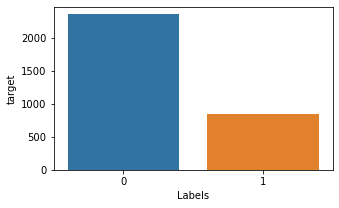

In [11]:
fig = plt.figure(figsize=(5,3))
ax = sns.barplot(x=df.target.unique(),y=df.target.value_counts());
ax.set(xlabel='Labels');
df.target.value_counts()

In [12]:
# We get the percentage of different between our classes
100 * (843/float(df.shape[0]))

26.34375

In [13]:
100 * (2357/float(df.shape[0]))

73.65625

So we do not have a class imbalance situation with a split of approx 74:26 between our classes. 
> If it is only 70%-30% there is probably no need to balance the dataset. The class imbalance problem is caused by not having enough patterns for the minority class, rather than a high ratio of positive to negative patterns. Generally, if you have enough data, the "class imbalance problem" doesn't arise. Also, note that if you artificially balance the dataset, you are implying an equal prior probability of positive and negative patterns. If that isn't true, your model may give bad predictions by over-predicting the minority class.

In [14]:
df.tweet.head(10), df.tweet.tail(10)

(0    Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia                              
 1    I get to spend New Year's home again alone and lonely. ???•                                                                                     
 2    Depressed and lonely /: Stuck in a deep, never ending hole :(                                                                                   
 3    If this is your response to someone saying they're dealing with , you're a terrible person.                                                     
 4    Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!                                                      
 5    When you will never again give birth to violent men..   pic.twitter.com/pkdPhhlUuZ                                                              
 6    Learning to pretend to have a good time had become a natural skill. I hope one day it is

Checking for Non-Depressive Tweets

In [15]:
df[df['target']==0].tweet.head()

0    Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia
3    If this is your response to someone saying they're dealing with , you're a terrible person.                       
4    Apparently you get a free pass just by mentioning    Where was I on the free badge day??!!                        
5    When you will never again give birth to violent men..   pic.twitter.com/pkdPhhlUuZ                                
7    Aw man im outta pizza rolls                                                                                       
Name: tweet, dtype: object

Checking for Depressive tweets

In [16]:
df[df['target']==1].tweet.head()

1     I get to spend New Year's home again alone and lonely. ???•                                     
2     Depressed and lonely /: Stuck in a deep, never ending hole :(                                   
6     Learning to pretend to have a good time had become a natural skill. I hope one day it is genuine
9     So far he stop texting me…after I said something…so hopefully he doesn't show up at my house…   
11    *sigh* ???? I haven't cried so much…I'm in so much pain…                                        
Name: tweet, dtype: object

### 2.1 Defining Our Preprocessing Rules : 

Torchtext has problems handling \n so first we need to remove them from our tweets and replace them with spaces. 

( This gave me a brief introduction into how regular expressions are used in modern NLP )

In [17]:
df['tweet'] = df.tweet.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|████████████████████████████████████████████████████████████████| 3200/3200 [00:00<00:00, 246108.49it/s]


Our contraction dicts will gives context for the contracted words and separate them out into it's contextual meaning in the language.

In [18]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [19]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

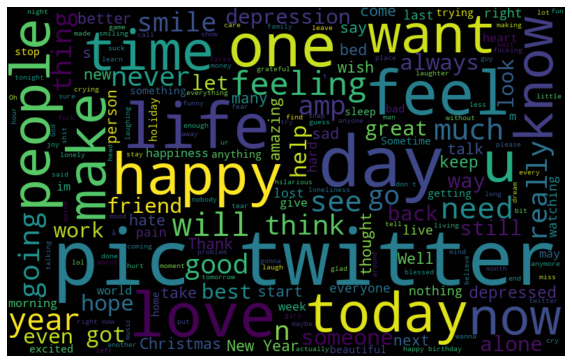

In [20]:
all_words = ' '.join([text for text in df['tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Detecting and Removing abnormalies in our tweets
Now we remove the unnecessary stuff from our tweets like URLs ( That may point towards advertisement ), Mentions ( That are most likely an anomaly case ), Emojis (Since they are random ), Hashtag symbols and Numbers. We also work on removing all symbols and punctuations expect for ., ! and ?

In [21]:
def tweet_clean(text):
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove urls
    text = re.sub(r'<([^>]*)>', ' ', text) # remove emojis
    text = re.sub(r'@\w+', ' ', text) # remove at mentions
    text = re.sub(r'#', '', text) # remove hashtag symbol
    text = re.sub(r'[0-9]+', ' ', text) # remove numbers
    text = replace_contractions(text)
    pattern = re.compile(r"[ \n\t]+")
    text = pattern.sub(" ", text)      
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))    
    text = re.sub(r'[^A-Za-z0-9,?.!]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    return text.strip()

Next we tokenize our tweets using spacy by making `tweet_clean(s)` as an `nlp` object.

In [22]:
nlp = spacy.load("en_core_web_sm",disable=['lemmatizer', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

### Defining fields


The field object takes arguments on how to process the tokenized text.

This field object will later be attached to the dataset -> `train_val-field`

In [23]:
# We define the fields for our tweets 
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab = True)
# We define the fields for our target variable. It does not need any tokenization since it is already in it's class form of 1s and 0s
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target=False)

In [24]:
# Here we assign our fields to our dataset
data_fields = [
    (None, None),
    ("tweet", TEXT), 
    ("target", TARGET)
]

# 3. Building our Train-Val-Test Datasets

I was honestly pretty confused on the significant differences between a test and validation datasets,

So I referred to this insanely dedicated article to have a better understanding for them. 
https://machinelearningmastery.com/difference-test-validation-datasets/#:~:text=%E2%80%93%20Validation%20set%3A%20A%20set%20of,of%20a%20fully%2Dspecified%20classifier.&text=These%20are%20the%20recommended%20definitions%20and%20usages%20of%20the%20terms.

> Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The validation set approach […] is a very simple strategy for this task. It involves randomly dividing the available set of observations into two parts, a training set and a validation set or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate — typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate.

In [25]:
# train-test-split -> 80:20
from sklearn.model_selection import train_test_split
def splitting_train_test(df, test_size = 0.2):
    train, val = train_test_split(df, test_size=test_size, random_state = 42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [26]:
# create train and validation set 
train_val, test = splitting_train_test(df, test_size=0.2)
train, val = splitting_train_test(train_val, test_size=0.2)

In [27]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [28]:
train.shape, val.shape, test.shape

((2048, 3), (512, 3), (640, 3))

#### Let us plot the newly created datasets

[Text(0.5, 0, 'Labels'), Text(0, 0.5, 'counts'), Text(0.5, 1.0, 'test')]

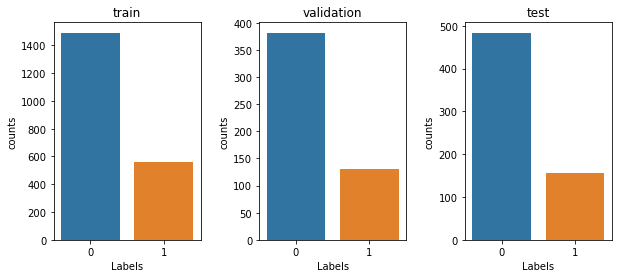

In [29]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

#### Converting to our train-val-test into `TabularDataset` for torchtext operations

In [30]:
%%time
train_data, val_data, test_data = TabularDataset.splits(path='./', format='csv', train='train.csv', validation='val.csv', test='test.csv', fields=data_fields, skip_header=True)

Wall time: 14.4 s


# 4. Loading our Vector embeddings and `build_vocab`
Torchtext makes loading of pretrained word vectors very easy. Just mention the name of the pretrained word vector (e.g. glove.6B.50d, fasttext.en.300d, etc.) and torchtext will download that particular vector and then you can use it in embedding layer.

In [31]:
len(train_data)

2048

In [32]:
%%time
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors="glove.6B.50d")

TARGET.build_vocab(train_data)

Wall time: 595 ms


In [33]:
TEXT.vocab.vectors.shape

torch.Size([5470, 50])

In [34]:
train_data

# 5. Loading Data in Batches

We will use the BucketIterator to access the Dataloader. It sorts data according to length of text, and groups similar length text in a batch, thus reducing the amount of padding required. It pads the batch according to the max length in that particular batch

In [35]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(3,3,3), 
                                            sort_key=lambda x: len(x.tweet),         # Used to order text sequences in batches
                                            device=None,                             
                                            sort_within_batch=True, 
                                            repeat=False)

In [36]:
len(train_loader), len(val_loader), len(test_loader)

(683, 171, 214)

Basically iter() calls the __iter__() method on the `train_loader` which returns an iterator. next() then calls the __next__() method on that iterator to get the first iteration. Running next() again will get the second item of the iterator, etc.

In [37]:
batch = next(iter(train_loader))
type(batch)

torchtext.data.batch.Batch

In [38]:
batch.target

tensor([0, 1, 0])

In [39]:
batch.tweet

(tensor([[ 397,  324,  588],
         [1639,  588,   13],
         [ 327,  219,   40],
         [   2,   37,  228],
         [  76,  250,  360]]),
 tensor([5, 5, 5]))

In [40]:
print (TEXT.vocab.itos[1],
TEXT.vocab.itos[2],
TEXT.vocab.itos[3],
TEXT.vocab.itos[4])

<pad> . ? i


In [41]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.tweet[0][:,idx].cpu().data.numpy()])

In [42]:
print(idxtosent(batch,0)," ",idxtosent(batch,1)," ", idxtosent(batch,2))

finished gossip girl . feeling   doing absolutely fuck all tonight   absolutely ! happy blessed tuesday


In [43]:
batch.__dict__

{'batch_size': 3,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1c55f99b1f0>,
 'fields': dict_keys([None, 'tweet', 'target']),
 'input_fields': ['tweet', 'target'],
 'target_fields': [],
 'tweet': (tensor([[ 397,  324,  588],
          [1639,  588,   13],
          [ 327,  219,   40],
          [   2,   37,  228],
          [  76,  250,  360]]),
  tensor([5, 5, 5])),
 'target': tensor([0, 1, 0])}

## Now let us define the BatchGenerator class. 
Most important components in a PyTorch Dataset class are:
__len__(self, ) where it returns the number of examples in our dataset that we read in __init__(self, ).

This will ensure that len() will return the number of examples.

The __iter__() function returns an iterator for the given object (array, set, tuple etc. or custom objects). It creates an object that can be accessed one element at a time using __next__() function, which generally comes in handy when dealing with loops.

In [44]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        # data loading
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        # len(dataset)
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [347]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
next(iter(train_batch_it)) # We define a training batch

((tensor([[   4,  495, 3662,  184,   27,   12, 1157,    3,    4,    9,  290,   60,
             99,   78,   71,    4],
          [1507, 2209,   38,  494,  285,   33,   17,    3,   63,  894,  123,  576,
            478,  284,  351, 1507],
          [  64,    7,  247,    5,   11,  664,  176,    3,    5,  615, 2822,  351,
            140,   10,    2,   64],
          [  23,  235,  158,   86,    9,   21,  970,    3,  954,   11,    7, 2802,
           2387,   28, 1275,   23],
          [  28,  102,   10,   25,  393,    4,  126,    3,   80,   16,    4,   13,
           2457,   24,  583,   28],
          [  61,   35,   40,  135, 1130,   63, 3441,    3,   50,   56,   30,    4,
              6,  174,   68,   61],
          [   8, 1732,   12,   36,   17,  528,   15,    3,   33,   19,   16,   22,
            351, 5213,  866,    8],
          [   4, 1523,  242,    4,  251,   60,   14,    3,  188,  251,   69,   59,
            106,    8,   46,    4],
          [ 436,    7, 4477,  805,    4,  121,  

In [ ]:
from niacin.augment import RandAugment


# 6. Models and Training

For model training I followed the example in https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8 along with some more studies from the https://github.com/swcwang/depression-detection who made small modifications by adding dropouts to lessen overfitting.

Our mode uses a pretrained embedding layer from glove that we imported using torchtext, a bidirecetional GRU and a concat pooling method where we perform average pool and max pool and then concatenate the results. 

We define our vocab_size our vector embedding dimensions and hidden layers for our neural network. 

## 2. Adaptive GRU

In [287]:
vocab_size = len(TEXT.vocab)
embedding_dim = 50
n_hidden = 64
n_out = 2

In [288]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True):
        super().__init__()   
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.fc = nn.Linear(self.n_hidden*2, self.n_out)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1) 
        
        cat = self.dropout(torch.cat([avg_pool,max_pool],dim=1))
        
        outp = self.fc(cat)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [289]:
def train(model, iterator, optimizer, criterion, num_batch):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
  
        #t = tqdm_notebook(iterator, leave=False, total=num_batch)
    
        for (X,lengths),y in iterator:

          #t.set_description(f'Epoch {epoch}')
          lengths = lengths.cpu().numpy()

          opt.zero_grad()
          pred = model(X, lengths)
          loss = criterion(pred, y)
          loss.backward()
          opt.step()

          #t.set_postfix(loss=loss.item())
          pred_idx = torch.max(pred, dim=1)[1]

          y_true_train += list(y.cpu().data.numpy())
          y_pred_train += list(pred_idx.cpu().data.numpy())
          total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/num_batch
        return train_loss, train_acc

In [290]:
def evaluate(model, iterator, criterion, num_batch):
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in iterator: #tqdm_notebook(iterator, leave=False): 
            
              pred = model(X, lengths.cpu().numpy())
              loss = criterion(pred, y)
              pred_idx = torch.max(pred, 1)[1]
              y_true_val += list(y.cpu().data.numpy())
              y_pred_val += list(pred_idx.cpu().data.numpy())
              total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/num_batch
            return valloss, valacc
         

In [291]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(16,16,16), 
                                            sort_key=lambda x: len(x.tweet), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [292]:
train_batch_it = BatchGenerator(train_loader, 'tweet', 'target')
val_batch_it = BatchGenerator(val_loader, 'tweet', 'target')
test_batch_it = BatchGenerator(test_loader, 'tweet', 'target')

In [323]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['tweet'].vocab.vectors, 0.5).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

In [324]:
loss_fn=F.nll_loss
epochs=10

In [345]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [326]:
from sklearn.metrics import accuracy_score

In [327]:
best_valid_loss = float('inf')

epochs=10

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), 'tut4-model.pt')
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f}')


<ipython-input-288-1b99873b3102>:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


Epoch 0: train_loss: 0.5706 train_acc: 0.7275 | val_loss: 0.5100 val_acc: 0.7520
Epoch 1: train_loss: 0.4952 train_acc: 0.7510 | val_loss: 0.4925 val_acc: 0.7539
Epoch 2: train_loss: 0.4726 train_acc: 0.7666 | val_loss: 0.4843 val_acc: 0.7695
Epoch 3: train_loss: 0.4395 train_acc: 0.7925 | val_loss: 0.4957 val_acc: 0.7695
Epoch 4: train_loss: 0.4109 train_acc: 0.8120 | val_loss: 0.4810 val_acc: 0.7637
Epoch 5: train_loss: 0.4105 train_acc: 0.8081 | val_loss: 0.4811 val_acc: 0.7617
Epoch 6: train_loss: 0.3853 train_acc: 0.8203 | val_loss: 0.4686 val_acc: 0.7754
Epoch 7: train_loss: 0.3668 train_acc: 0.8330 | val_loss: 0.5114 val_acc: 0.7461
Epoch 8: train_loss: 0.3631 train_acc: 0.8340 | val_loss: 0.4887 val_acc: 0.7832
Epoch 9: train_loss: 0.3399 train_acc: 0.8472 | val_loss: 0.5050 val_acc: 0.7715


In [344]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.466 | Test Acc: 77.66%


<ipython-input-288-1b99873b3102>:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outp)


## Improving Accuracy of our Model
Now that we have gained an average accuracy of 76% let us look into how to improve this performance. 

### Hyper Parameter Tuning
1. On reducing the batch size we gain an average val_acc of 78%
2. Reducing the number of hidden layers -> Decreases the accuracy so we reset
3. Increasing the dropout rate also reduces the accuracy so we skip
4. Applying Data Augmentation